<a href="https://colab.research.google.com/github/deepankar27/ML_Tutorials/blob/master/NLP/Siamese_nw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_hub as hub

import keras
import keras.backend as K
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras import Model
from keras.layers import Input, Layer
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers import Bidirectional, LSTM

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

import pickle    
import os

import matplotlib.pyplot as plt

In [ ]:
file_path = '/content/Data'

test = pd.read_csv(os.path.join(file_path,'final_fewshot_test.csv'))
train = pd.read_csv(os.path.join(file_path,'final_fewshot_train.csv'))

train = train[['text','class']]
test = test[['text','class']]

In [ ]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/4'
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.load(module_url)

In [ ]:
#Creating a network

input_text1 = Input(shape=(512,))
x = Dense(256, activation='relu')(input_text1)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = Dropout(0.4)(x)
dense_layer = Dense(128, name='dense_layer')(x)
norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)
model=Model(inputs=[input_text1], outputs=norm_layer)

model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_91 (InputLayer)        [(None, 512)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_layer (Dense)          (None, 128)               8320

In [ ]:
#Now create Siamese aspects

# Input for anchor, positive and negative images
in_a = Input(shape=(512,))
in_p = Input(shape=(512,))
in_n = Input(shape=(512,))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = model(in_a)
emb_p = model(in_p)
emb_n = model(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.4, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [ ]:
#Now create Siamese aspects with new loss function

# Input for anchor, positive and negative images
in_a = Input(shape=(512,))
in_p = Input(shape=(512,))
in_n = Input(shape=(512,))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = model(in_a)
emb_p = model(in_p)
emb_n = model(in_n)

class New_TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(New_TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        N = 128
        epsilon=1e-8
        #p_dist = K.sum(K.square(a-p), axis=-1)
        #n_dist = K.sum(K.square(a-n), axis=-1)
        p_dist = tf.math.reduce_sum(tf.math.square(tf.math.subtract(a,p)),1)
        n_dist = tf.math.reduce_sum(tf.math.square(tf.math.subtract(a,n)),1)
        #Non Linear Values
        p_dist = -tf.math.log(-tf.math.divide((p_dist),N)+1+epsilon)
        n_dist = -tf.math.log(-tf.math.divide(int(N-n_dist),N)+1+epsilon)
        #compute loss
        loss = tf.cast(p_dist, tf.float32) + tf.cast(n_dist, tf.float32)
        return loss
    
    def call(self, inputs):
        
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
#triplet_loss_layer = TripletLossLayer(alpha=0.4, name='triplet_loss_layer')([emb_a, emb_p, emb_n])
triplet_loss_layer = New_TripletLossLayer(alpha=0.4, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [ ]:
#creating the necessary datastructures for selcting triplets
unique_train_label = np.array(train['class'].unique().tolist())
labels_train = np.array(train['class'].tolist())
map_train_label_indices = {label: np.flatnonzero(labels_train == label) for label in unique_train_label}

In [ ]:
def get_triplets(unique_train_label,map_train_label_indices):
      label_l, label_r = np.random.choice(unique_train_label, 2, replace=False)
      a, p = np.random.choice(map_train_label_indices[label_l],2, replace=False)
      n = np.random.choice(map_train_label_indices[label_r])
      return a, p, n

def get_triplets_batch(k, train_set, unique_train_label, map_train_label_indices, embed):

    while True:
      idxs_a, idxs_p, idxs_n = [], [], []
      for _ in range(k):
          a, p, n = get_triplets(unique_train_label, map_train_label_indices)
          idxs_a.append(a)
          idxs_p.append(p)
          idxs_n.append(n)

      a=train_set.iloc[idxs_a].values.tolist()
      b=train_set.iloc[idxs_p].values.tolist()
      c=train_set.iloc[idxs_n].values.tolist()

      a = embed(a)
      p = embed(b)
      n = embed(c)
        # return train_set[idxs_a], train_set[idxs_p], train_set[idxs_n]
      yield [a,p,n], []

In [ ]:
#train the network
nn4_small2_train.compile(loss=None, optimizer='adam')
nn4_small2_train.fit(get_triplets_batch(128,train['text'],unique_train_label,map_train_label_indices,embed), 
                     epochs=100, steps_per_epoch=10)


Epoch 1/100


ValueError: ignored

In [ ]:
#getting the embeddings from the model
X_train = model.predict(embed(np.array(train['text'].values.tolist()))['outputs'])
X_test = model.predict(embed(np.asarray(test['text'].values.tolist()))['outputs'])

y_train = np.array(train['class'].values.tolist())
y_test = np.array(test['class'].values.tolist())

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
y_pred_svc = svc.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred_svc)

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.878547451937748, SVM accuracy = 0.878547451937748


In [ ]:
#on 200 epoachs
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
y_pred_svc = svc.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred_svc)

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.878547451937748, SVM accuracy = 0.878547451937748


In [ ]:
from sklearn import metrics
print(metrics.classification_report(list(y_test), list(y_pred_knn)))

              precision    recall  f1-score   support

           1       0.93      0.90      0.91      1072
           2       0.61      0.87      0.72       262
           3       0.91      0.77      0.83       425
           4       0.88      0.87      0.88       532
           5       0.92      0.90      0.91       986

    accuracy                           0.88      3277
   macro avg       0.85      0.86      0.85      3277
weighted avg       0.89      0.88      0.88      3277



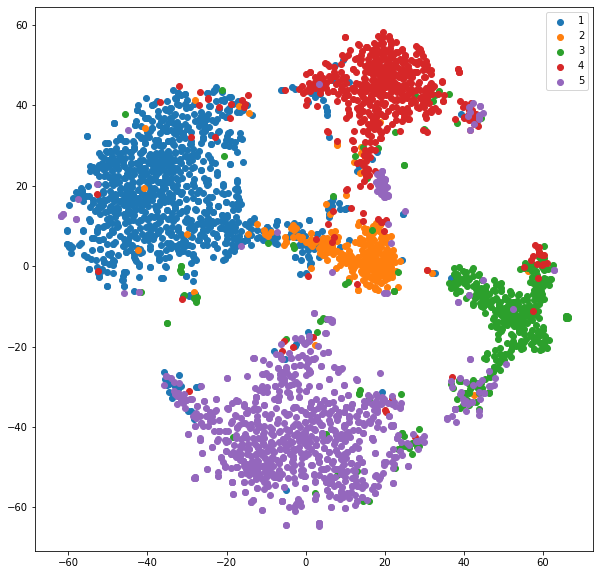

In [ ]:
#this is after 100 epoch

X_embedded = TSNE(n_components=2).fit_transform(X_test)

plt.figure(figsize=(10,10))

for i, t in enumerate(set(y_test)):
    idx = y_test == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

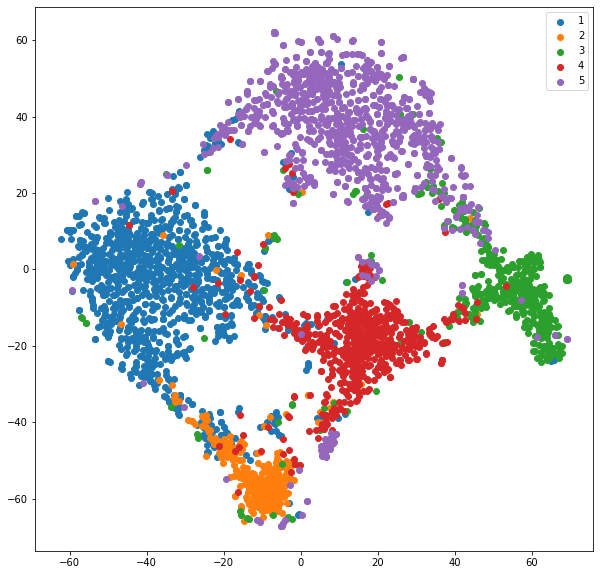

In [ ]:
#this is after 200 epoch

X_embedded = TSNE(n_components=2).fit_transform(X_test)

plt.figure(figsize=(10,10))

for i, t in enumerate(set(y_test)):
    idx = y_test == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));